In [9]:
# %%
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import time
import math
import datetime

# Simulation inputs

In [21]:
latitude=42.567055
longitude=12.607027
surface_tilt=0 
surface_azimuth=180
startyear=2010
endyear=2020
freq='h'
modules_per_string=25
strings_per_inverter=215
altitude=0


In [22]:
module_name = 'Canadian_Solar_CS5P_220M___2009_'
inverter_name = 'ABB__ULTRA_1100_TL_OUTD_2_US_690_x_y_z__690V_' #'Power_Electronics__FS3000CU15__690V_' #'ABB__PVS980_58_2000kVA_K__660V_' #'ABB__ULTRA_1100_TL_OUTD_2_US_690_x_y_z__690V_'
location=Location(latitude, longitude, tz='Europe/Rome', altitude=altitude)

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod') 
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules[module_name]
inverter = sapm_inverters[inverter_name]
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

system=PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth,
                module_parameters=module, inverter_parameters=inverter,
                temperature_model_parameters=temperature_model_parameters,
                modules_per_string=modules_per_string, strings_per_inverter=strings_per_inverter
                )

# Get weather from PVGIS

In [23]:
# %%
tmy=pvlib.iotools.get_pvgis_tmy(latitude, 
                            longitude, 
                            outputformat='csv', 
                            usehorizon=True, 
                            userhorizon=None, 
                            startyear=startyear, 
                            endyear=endyear, 
                            map_variables=True, 
                            url='https://re.jrc.ec.europa.eu/api/v5_2/', 
                            timeout=30)[0]
tmy.to_csv('./pvgis_tmy.csv', index=True)
tmy.head()

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
2019-01-01 00:00:00+00:00,2.64,78.27,0.0,-0.0,0.0,260.15,1.38,355.0,101301.0
2019-01-01 01:00:00+00:00,2.29,77.21,0.0,-0.0,0.0,255.94,1.53,355.0,101301.0
2019-01-01 02:00:00+00:00,1.95,76.15,0.0,-0.0,0.0,251.74,1.67,355.0,101301.0
2019-01-01 03:00:00+00:00,1.60,75.09,0.0,-0.0,0.0,247.53,1.81,355.0,101271.0
2019-01-01 04:00:00+00:00,1.25,74.04,0.0,-0.0,0.0,243.33,1.95,355.0,101242.0


# Extend duration after 2020 if needed...

In [25]:
def days_between_dates(dt1, dt2):
    date_format = "%Y-%m-%d %H:%M:%S+00:00"
    a = time.mktime(time.strptime(dt1, date_format))
    b = time.mktime(time.strptime(dt2, date_format))
    delta = abs(b - a)
    return delta / (60 * 60 * 24)  # Convert seconds to days

start="2022-01-01 00:00:00+00:00"
end="2023-08-31 23:00:00+00:00"

num_days = days_between_dates(start, end)
num_years = math.ceil(num_days / 365)

# %%
def extend_tmy_data(df, num_years):
    extended_dfs = []
    for year_offset in range(int(num_years)):
        extended_dfs.append(df.copy())
    extended_data = pd.concat(extended_dfs, ignore_index=True)
    return extended_data

# %%
extended_tmy_data = extend_tmy_data(tmy, num_years)
extended_tmy_data.index=pd.date_range(start=start, periods=len(extended_tmy_data), freq=freq)
extended_tmy_data_new=extended_tmy_data[start:end]
tmy = extended_tmy_data_new
tmy.head()

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
2022-01-01 00:00:00+00:00,2.64,78.27,0.0,-0.0,0.0,260.15,1.38,355.0,101301.0
2022-01-01 01:00:00+00:00,2.29,77.21,0.0,-0.0,0.0,255.94,1.53,355.0,101301.0
2022-01-01 02:00:00+00:00,1.95,76.15,0.0,-0.0,0.0,251.74,1.67,355.0,101301.0
2022-01-01 03:00:00+00:00,1.60,75.09,0.0,-0.0,0.0,247.53,1.81,355.0,101271.0
2022-01-01 04:00:00+00:00,1.25,74.04,0.0,-0.0,0.0,243.33,1.95,355.0,101242.0


## PV generation simulation

In [26]:
modelchain=ModelChain(system, location)

# %%
data=tmy
data.index=pd.to_datetime(data.index)

# %%
modelchain.run_model(data)
solar_data=modelchain.results.ac
solar_data=pd.DataFrame(solar_data, columns=(['Terni_solar_generation']))

solar_data.loc[solar_data['Terni_solar_generation'] < 0, 'Terni_solar_generation'] = 0

# Convert Watt to kW
solar_data/=1000
solar_data.to_csv('./Terni_solar_data.csv', index_label=['Datetime'])

# %%
solar_data.head(20)

,Terni_solar_generation
2022-01-01 00:00:00+00:00,0.000000
2022-01-01 01:00:00+00:00,0.000000
2022-01-01 02:00:00+00:00,0.000000
2022-01-01 03:00:00+00:00,0.000000
2022-01-01 04:00:00+00:00,0.000000
2022-01-01 05:00:00+00:00,0.000000
2022-01-01 06:00:00+00:00,0.000000
2022-01-01 07:00:00+00:00,0.000000
2022-01-01 08:00:00+00:00,153.449559
2022-01-01 09:00:00+00:00,312.411190


In [27]:
solar_data.describe()


,Terni_solar_generation
count,14592.000000
mean,201.118860
std,287.489188
min,0.000000
25%,0.000000
50%,0.000000
75%,363.366300
max,979.730847


<Axes: >

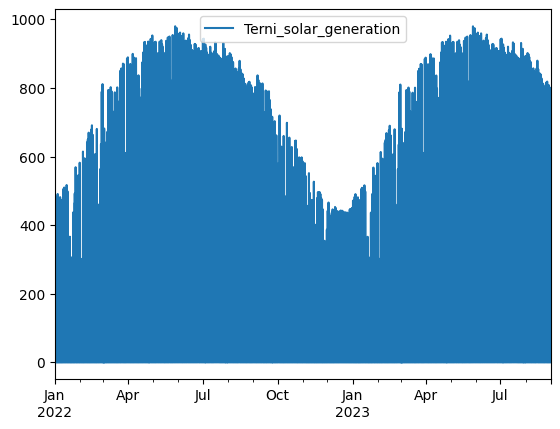

In [28]:
solar_data.plot()